In [97]:
import pandas as pd
import numpy as np
import statistics
import datetime

import matplotlib.pyplot as plt
#import dataframe_image as dfi

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer 
from sklearn.decomposition import LatentDirichletAllocation
import re

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#import pyLDAvis.gensim
#import pickle 
#import pyLDAvis

from afinn import Afinn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abbyr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
articles = pd.read_csv('data/articles_df.csv')

In [3]:
articles.head(10)

,text,title,date,outlet,datetime_obj,covid
0,'A momentous decision': What the resolution of...,'A momentous decision' What the resolution of ...,"May 14, 2020",Newstex Blogs,2020-05-14,1.0
1,'A nice uplift for the community'; Fort Chipew...,'A nice uplift for the community'; Fort Chipew...,"November 7, 2019",Fort McMurray Today,2019-11-07,0.0
2,'A societal crisis': Does this UMKC program ha...,'A societal crisis' Does this UMKC program hav...,"December 7, 2021",Newstex Blogs,2021-12-07,1.0
3,'Abbott Elementary'; School veteran shares wha...,'Abbott Elementary' School veteran shares what...,"December 7, 2021",The Philadelphia Inquirer,2021-12-07,1.0
4,'FALL INTO TEACHING' EVENT CELEBRATES BOOK REL...,'FALL INTO TEACHING' EVENT CELEBRATES BOOK REL...,"September 6, 2019",US Fed News,2019-09-06,0.0
5,'I'm looking to re-energize and build': Clarks...,'I'm looking to re-energize and build' Clarksd...,"August 8, 2019",Newstex Blogs,2019-08-08,0.0
6,'I'm not going to waste my time on prayers'Jpo...,'I'm not going to waste my time on prayers',"February 18, 2022",Jpost.com (The Jerusalem Post online edition),2022-02-18,1.0
7,'I'm not going to waste my time on prayers': h...,'I'm not going to waste my time on prayers' ho...,"February 8, 2022",EveningReport.nz,2022-02-08,1.0
8,'I'm not going to waste my time on prayers': h...,'I'm not going to waste my time on prayers' ho...,"August 31, 2022",MENAFN - Business & Finance News (English),2022-08-31,1.0
9,'I'm not going to waste my time on prayers': h...,'I'm not going to waste my time on prayers' ho...,"February 7, 2022",The Conversation - Australia,2022-02-07,1.0


In [4]:
# Clean up outlet name
outlets = []
for article in articles["outlet"]:
    outlet = article.strip()
    if outlet == '':
        outlet = np.nan
    outlets.append(outlet)

articles["outlet"] = outlets

In [5]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          1503 non-null   object 
 1   title         1503 non-null   object 
 2   date          1347 non-null   object 
 3   outlet        1479 non-null   object 
 4   datetime_obj  1347 non-null   object 
 5   covid         1347 non-null   float64
dtypes: float64(1), object(5)
memory usage: 70.6+ KB


In [6]:
articles.covid.value_counts()/articles.shape[0]

1.0    0.613440
0.0    0.282768
Name: covid, dtype: float64

In [7]:
articles.covid.isna().sum()/articles.shape[0]

0.10379241516966067

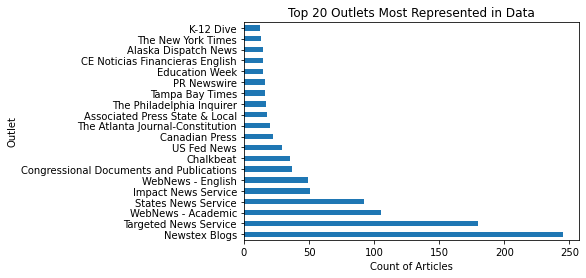

In [8]:
top_outlets = articles.outlet.value_counts().head(20)
ax = top_outlets.plot(kind='barh',
                 xlabel="Count of Articles", 
                 ylabel='Outlet', 
                 title="Top 20 Outlets Most Represented in Data")
fig = ax.get_figure()
fig.savefig('plots/outlet_value_count_barplot.png')

In [9]:
top_outlets/articles.shape[0]

Newstex Blogs                               0.163007
Targeted News Service                       0.119760
WebNews - Academic                          0.069860
States News Service                         0.061211
Impact News Service                         0.033932
WebNews - English                           0.032601
Congressional Documents and Publications    0.024617
Chalkbeat                                   0.023287
US Fed News                                 0.019295
Canadian Press                              0.014637
The Atlanta Journal-Constitution            0.013307
Associated Press State & Local              0.011976
The Philadelphia Inquirer                   0.011311
Tampa Bay Times                             0.010645
PR Newswire                                 0.010645
Education Week                              0.009980
CE Noticias Financieras English             0.009980
Alaska Dispatch News                        0.009980
The New York Times                          0.

In [10]:
articles.outlet.isna().sum()/articles.shape[0]

0.015968063872255488

In [11]:
articles.outlet.value_counts().head(13).sum()/articles.shape[0]

0.5988023952095808

In [12]:
doc_lengths = []
for article in articles.text:
    tokenized_doc = nltk.tokenize.word_tokenize(article)
    doc_length = len(tokenized_doc)
    doc_lengths.append(doc_length)

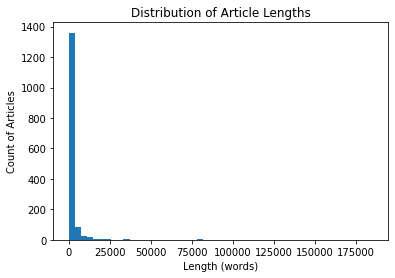

In [13]:
doc_lengths_series = pd.Series(data=doc_lengths, name='doc_length')
plt.title("Distribution of Article Lengths")
plt.xlabel("Length (words)")
plt.ylabel("Count of Articles")
plt.hist(doc_lengths_series, bins=50)
plt.savefig("plots/doc_length_histogram.png")
plt.show()

In [14]:
doc_lengths_series.describe()

count      1503.000000
mean       1970.290752
std        6121.897269
min          26.000000
25%         599.000000
50%        1003.000000
75%        1748.500000
max      185428.000000
Name: doc_length, dtype: float64

In [15]:
articles = pd.concat([articles, doc_lengths_series], axis=1)
articles.head()

,text,title,date,outlet,datetime_obj,covid,doc_length
0,'A momentous decision': What the resolution of...,'A momentous decision' What the resolution of ...,"May 14, 2020",Newstex Blogs,2020-05-14,1.0,1890
1,'A nice uplift for the community'; Fort Chipew...,'A nice uplift for the community'; Fort Chipew...,"November 7, 2019",Fort McMurray Today,2019-11-07,0.0,390
2,'A societal crisis': Does this UMKC program ha...,'A societal crisis' Does this UMKC program hav...,"December 7, 2021",Newstex Blogs,2021-12-07,1.0,2197
3,'Abbott Elementary'; School veteran shares wha...,'Abbott Elementary' School veteran shares what...,"December 7, 2021",The Philadelphia Inquirer,2021-12-07,1.0,1254
4,'FALL INTO TEACHING' EVENT CELEBRATES BOOK REL...,'FALL INTO TEACHING' EVENT CELEBRATES BOOK REL...,"September 6, 2019",US Fed News,2019-09-06,0.0,690


In [16]:
datetime.date.fromisoformat(articles["datetime_obj"][0])

datetime.date(2020, 5, 14)

In [17]:
converted_dates = []
for article in articles["datetime_obj"]:
    if pd.isna(article) == True:
        # Convert string text to valid ISO 8601 format
        #formatted_date = mdy_to_ymd(article)
        # Convert to datetime object
        converted_date = None
    else:
        converted_date = datetime.date.fromisoformat(article)
    converted_dates.append(converted_date)
    #index=index+1
articles["datetime_obj"] = converted_dates

In [18]:
ym_dates = []
for article in articles["datetime_obj"]:
    if pd.isna(article) == True:
        # Convert string text to valid ISO 8601 format
        #formatted_date = mdy_to_ymd(article)
        # Convert to datetime object
        converted_date = None
    else:
        converted_date = article.strftime('%Y-%m')
    ym_dates.append(converted_date)
    #index=index+1
articles["year-month"] = ym_dates

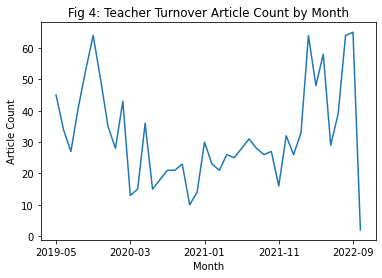

In [19]:
ax = articles["year-month"].value_counts().sort_index().plot(xlabel="Month", 
                                                            ylabel='Article Count', 
                                                            title="Fig 4: Teacher Turnover Article Count by Month")
fig = ax.get_figure()
fig.savefig('plots/article_count_bydate.png')

In [20]:
list(articles.datetime_obj.value_counts().sort_index())

[1,
 1,
 1,
 2,
 3,
 3,
 1,
 5,
 1,
 3,
 4,
 1,
 2,
 1,
 5,
 1,
 1,
 4,
 1,
 4,
 4,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 4,
 2,
 1,
 1,
 5,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 3,
 3,
 1,
 2,
 1,
 1,
 1,
 3,
 4,
 2,
 4,
 4,
 4,
 3,
 1,
 1,
 2,
 1,
 4,
 1,
 1,
 1,
 2,
 2,
 3,
 3,
 1,
 2,
 3,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 4,
 5,
 2,
 2,
 7,
 1,
 2,
 4,
 1,
 9,
 3,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 4,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 4,
 5,
 1,
 1,
 1,
 2,
 1,
 3,
 4,
 2,
 1,
 1,
 2,
 2,
 6,
 2,
 3,
 2,
 1,
 1,
 2,
 4,
 1,
 5,
 3,
 1,
 2,
 5,
 1,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 3,
 4,
 1,
 1,
 1,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 1,
 1,
 2,
 1,
 4,
 1,
 3,
 5,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 5,
 1,
 2,
 6,
 1,
 2,
 8,
 1,
 1,
 1,
 1,
 2,


In [21]:
articles[articles["doc_length"] > 3500].shape

(156, 8)

In [126]:
articles_without_outliers = articles[articles["doc_length"] <= 3500]
articles_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 0 to 1502
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          1347 non-null   object 
 1   title         1347 non-null   object 
 2   date          1192 non-null   object 
 3   outlet        1329 non-null   object 
 4   datetime_obj  1192 non-null   object 
 5   covid         1192 non-null   float64
 6   doc_length    1347 non-null   int64  
 7   year-month    1192 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 94.7+ KB


In [23]:
articles_without_outliers.doc_length.describe()

count    1347.000000
mean     1060.593912
std       744.022710
min        26.000000
25%       554.000000
50%       915.000000
75%      1415.000000
max      3491.000000
Name: doc_length, dtype: float64

In [24]:
lemmatizer = nltk.stem.WordNetLemmatizer()

class LemmatizerCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmatizerCountVectorizer, self).build_analyzer()
        return lambda doc: ([lemmatizer.lemmatize(w) for w in analyzer(doc)])
StopWords = stopwords.words('english')
newStopWords = ['2019end','2020end','2021end','2022end','b','c','d','e','s','www','school','teacher','student','newstex','http','wordsbyline','llc','com']
StopWords.extend(newStopWords)
vect = LemmatizerCountVectorizer(stop_words=StopWords, min_df=150, max_features=500, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
dtm = vect.fit_transform(articles["text"])
dtm_df = pd.DataFrame(dtm.toarray(), columns=list(vect.get_feature_names_out()))
dtm_df.shape

(1503, 500)

In [25]:
dtm_df.head()

,able,academic,access,according,achievement,across,act,action,activity,addition,...,word,work,worker,workforce,working,world,would,year,york,young
0,0,0,3,0,1,0,1,0,0,0,...,1,0,0,0,0,1,13,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,1,1,0,0
2,2,0,0,2,0,0,1,0,0,0,...,0,7,0,0,3,0,4,14,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,5,1,0,0,0,2,4,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [26]:
list(vect.get_feature_names_out())

['able',
 'academic',
 'access',
 'according',
 'achievement',
 'across',
 'act',
 'action',
 'activity',
 'addition',
 'additional',
 'address',
 'administration',
 'administrator',
 'age',
 'agency',
 'already',
 'also',
 'always',
 'america',
 'american',
 'among',
 'analysis',
 'another',
 'application',
 'approach',
 'area',
 'around',
 'art',
 'article',
 'assessment',
 'assistant',
 'association',
 'author',
 'available',
 'average',
 'back',
 'based',
 'become',
 'behavior',
 'believe',
 'benefit',
 'best',
 'better',
 'bill',
 'billion',
 'black',
 'board',
 'budget',
 'build',
 'building',
 'business',
 'california',
 'call',
 'called',
 'campus',
 'candidate',
 'care',
 'career',
 'case',
 'center',
 'chalkbeat',
 'challenge',
 'change',
 'charter',
 'child',
 'childhood',
 'city',
 'class',
 'classroom',
 'clear',
 'co',
 'college',
 'color',
 'come',
 'commitment',
 'committee',
 'community',
 'company',
 'compared',
 'concern',
 'condition',
 'content',
 'continue',
 'con

In [27]:
dtm_no_outliers = vect.fit_transform(articles_without_outliers["text"])
dtm_no_outliers_df = pd.DataFrame(dtm_no_outliers.toarray(), columns=list(vect.get_feature_names_out()))
dtm_no_outliers_df.shape

(1347, 500)

In [28]:
dtm_no_outliers_df.head()

,able,academic,access,according,achievement,across,act,action,added,additional,...,worked,worker,workforce,working,world,would,year,yet,york,young
0,0,0,3,0,1,0,1,0,0,0,...,0,0,0,0,1,13,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,2,0,0,2,0,0,1,0,0,2,...,1,0,0,3,0,4,14,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,2,1,0,0,0,2,4,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [30]:
vect.vocabulary_

{'decision': 96,
 'case': 55,
 'could': 81,
 'mean': 264,
 'blog': 44,
 'thursday': 457,
 'pm': 323,
 'estcopyright': 130,
 'right': 383,
 'reservedlength': 375,
 'chalkbeat': 57,
 'http': 198,
 'org': 304,
 'delivered': 98,
 'student': 430,
 'federal': 143,
 'last': 231,
 'month': 277,
 'performance': 319,
 'condition': 77,
 'public': 349,
 'school': 390,
 'clear': 65,
 'whether': 485,
 'would': 495,
 'u': 468,
 'official': 295,
 'four': 159,
 'state': 421,
 'policy': 325,
 'change': 59,
 'education': 114,
 'funding': 163,
 'real': 358,
 'research': 373,
 'found': 157,
 'better': 39,
 'result': 379,
 'time': 458,
 'set': 401,
 'low': 254,
 'educational': 115,
 'quality': 352,
 'learning': 238,
 'another': 22,
 'issue': 217,
 'year': 496,
 'come': 70,
 'said': 387,
 'law': 232,
 'professor': 343,
 'recent': 362,
 'asked': 28,
 'way': 481,
 'still': 424,
 'might': 272,
 'read': 356,
 'big': 40,
 'national': 282,
 'one': 298,
 'access': 2,
 'say': 389,
 'decade': 95,
 'strategy': 426,
 '

In [31]:
term_freq_dict = {'term': list(vect.get_feature_names_out()), 'freq':list(dtm_no_outliers_df.sum(axis=0))}
term_freq_df = pd.DataFrame.from_dict(data=term_freq_dict)
term_freq_df

,term,freq
0,able,426
1,academic,759
2,access,807
3,according,836
4,achievement,518
...,...,...
495,would,2164
496,year,6427
497,yet,344
498,york,543


In [32]:
most_common_words = term_freq_df.sort_values(by='freq', ascending=False).head(15)

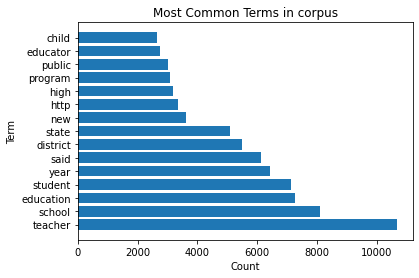

In [95]:
plt.barh(most_common_words['term'], most_common_words['freq'])
plt.title("Most Common Terms in corpus")
plt.xlabel("Count")
plt.ylabel("Term")
plt.savefig("plots/common_words_bar.png")
plt.show()

In [34]:
# Convert count vectorizer matrix to tf-idf vectorizer matrix
transformer = TfidfTransformer()
tfidf_trans = transformer.fit_transform(dtm_no_outliers_df)
tfidf_trans_df = pd.DataFrame(tfidf_trans.toarray(), index = dtm_no_outliers_df.index, columns=dtm_no_outliers_df.columns)

In [35]:
tfidf_trans_df.head()

,able,academic,access,according,achievement,across,act,action,added,additional,...,worked,worker,workforce,working,world,would,year,yet,york,young
0,0.000000,0.0,0.066639,0.000000,0.024738,0.000000,0.024377,0.000000,0.0,0.0000,...,0.000000,0.000000,0.0,0.000000,0.025788,0.200811,0.011515,0.0,0.0,0.025151
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.067651,0.050431,0.0,0.0,0.000000
2,0.037091,0.0,0.000000,0.030403,0.000000,0.000000,0.019211,0.000000,0.0,0.0363,...,0.020587,0.000000,0.0,0.041491,0.000000,0.048693,0.127045,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.054824,0.0,0.0000,...,0.103394,0.055026,0.0,0.000000,0.000000,0.061137,0.091150,0.0,0.0,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.035334,0.000000,0.000000,0.0,0.0000,...,0.000000,0.000000,0.0,0.036048,0.000000,0.031729,0.000000,0.0,0.0,0.000000


### LDA

In [36]:
# LDA analysis
LDA = LatentDirichletAllocation(n_components=8,random_state=0)

In [37]:
# document-topic matrix (probabilities)
theta = LDA.fit_transform(tfidf_trans_df)
theta.shape

(1347, 8)

In [38]:
# topic-word matrix
beta = LDA.components_
beta.shape

(8, 500)

In [39]:
beta_prob = LDA.components_ / LDA.components_.sum(axis=1)[:, np.newaxis]

In [40]:
# Define top words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, '\n')
    print()

In [41]:
features = vect.get_feature_names_out()
print_top_words(model=LDA, feature_names = features, n_top_words = 20)

Topic #0: leaving shortage state effort analysis problem end teacher united due crisis academic university recent health reason real address covid news 

Topic #1: rural science education technology bill access community student act improve research online house workforce math opportunity committee challenge give school 

Topic #2: teacher said school student district education year state http new program educator high child public news one teaching org support 

Topic #3: shortage real reason news end union investment called u teacher back keep crisis five evidence little leader teaching education document 

Topic #4: child year grade parent practice decision age home day student making every policy recruitment need june learning education whether skill 

Topic #5: monday news review place wednesday country part report end national tuesday way many number thursday make document press story home 

Topic #6: charter school public interest org private economy problem free non delivered c

In [116]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

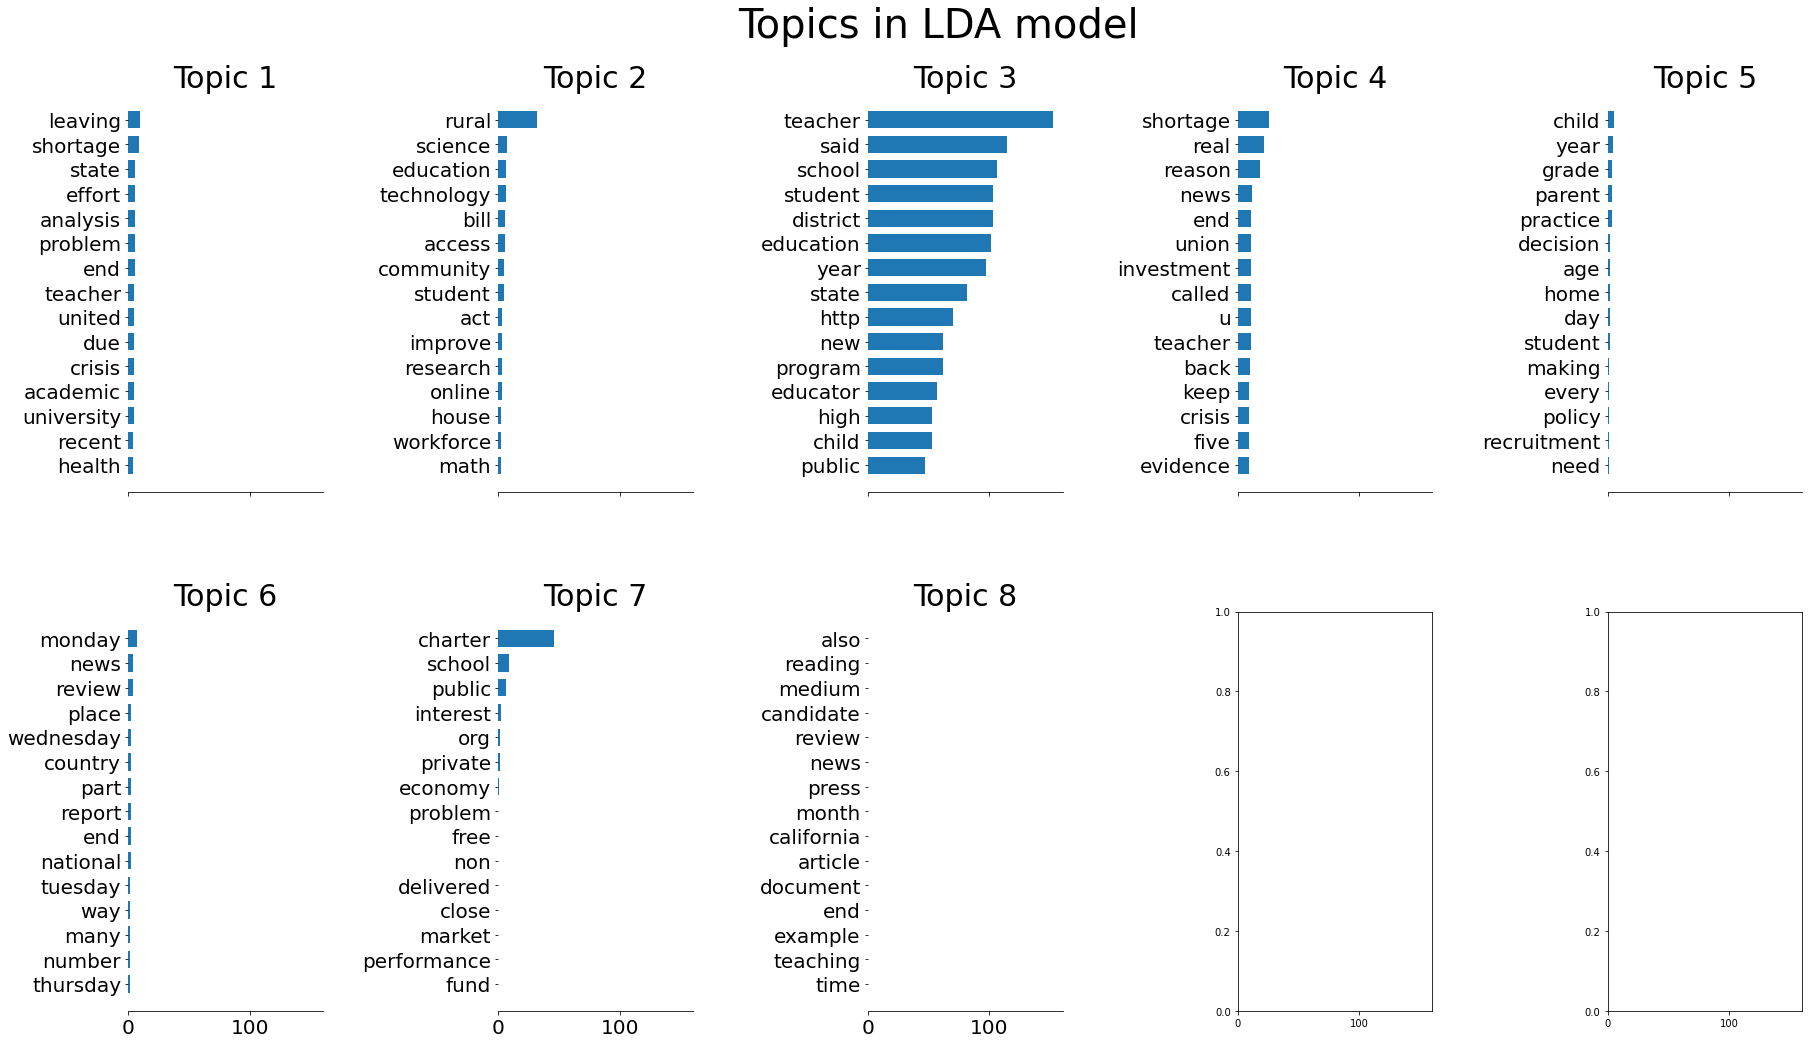

In [43]:
plot_top_words(LDA, features, 15, "Topics in LDA model")

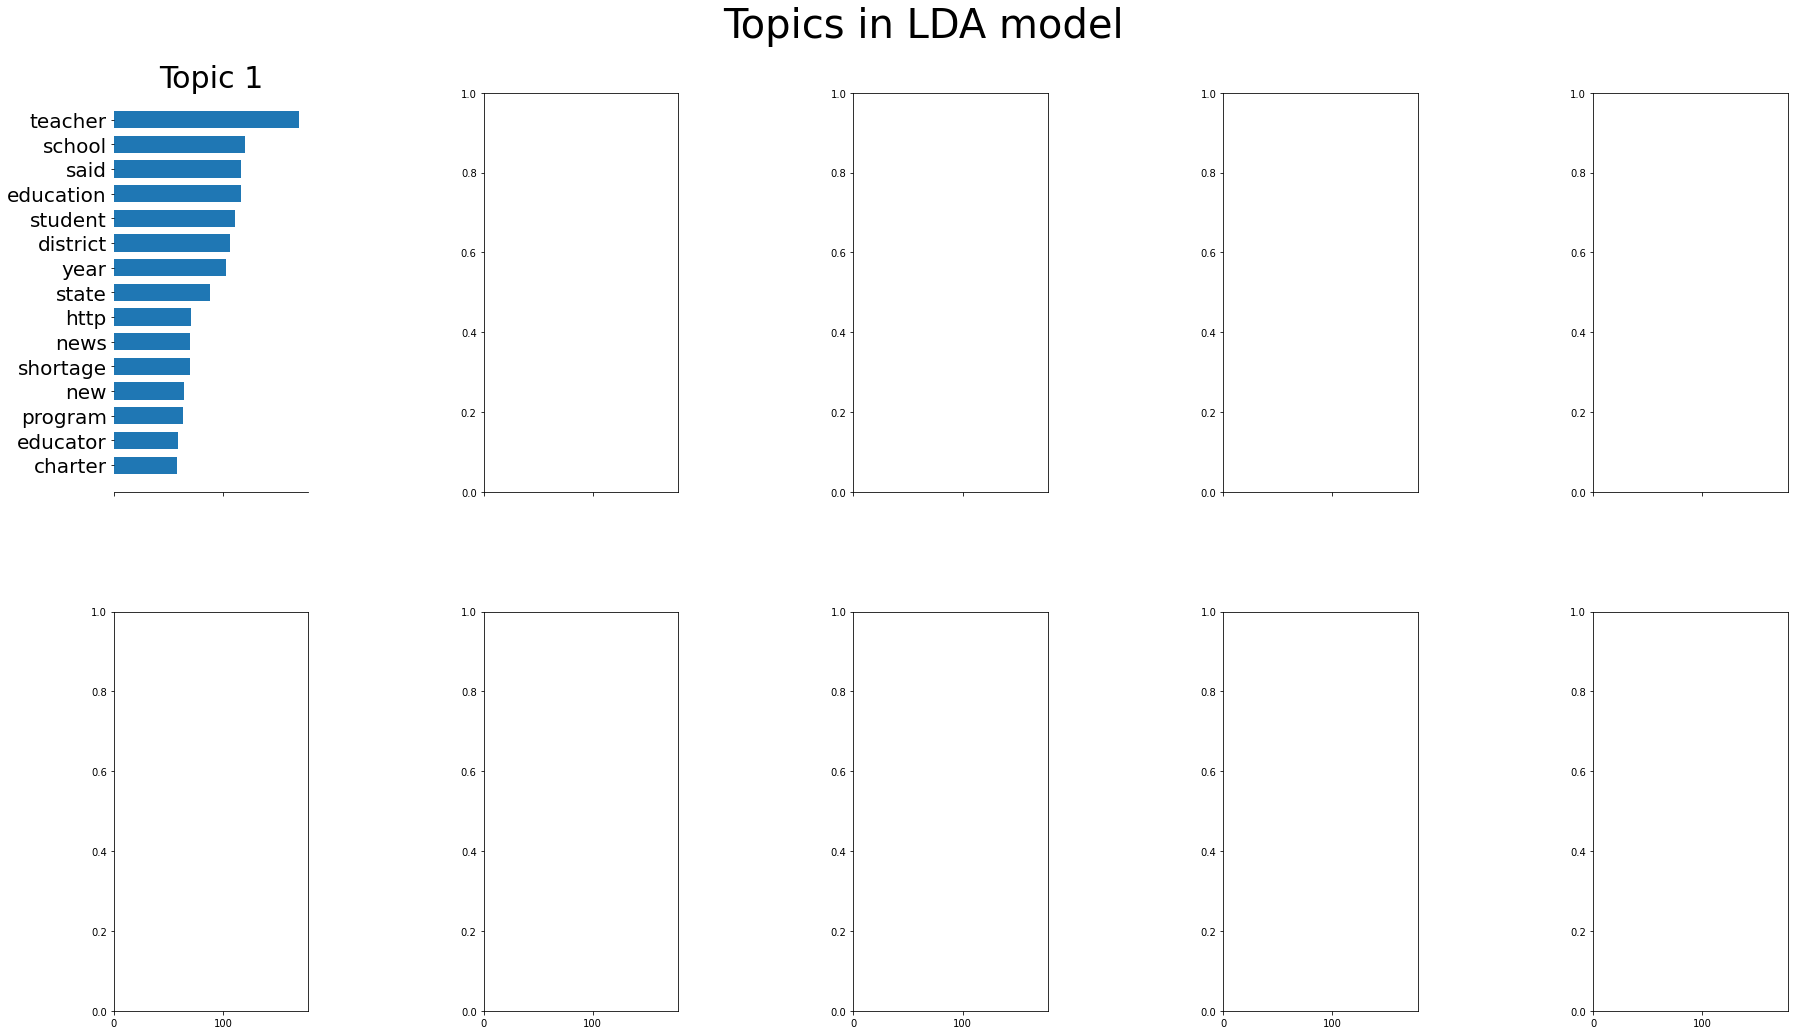

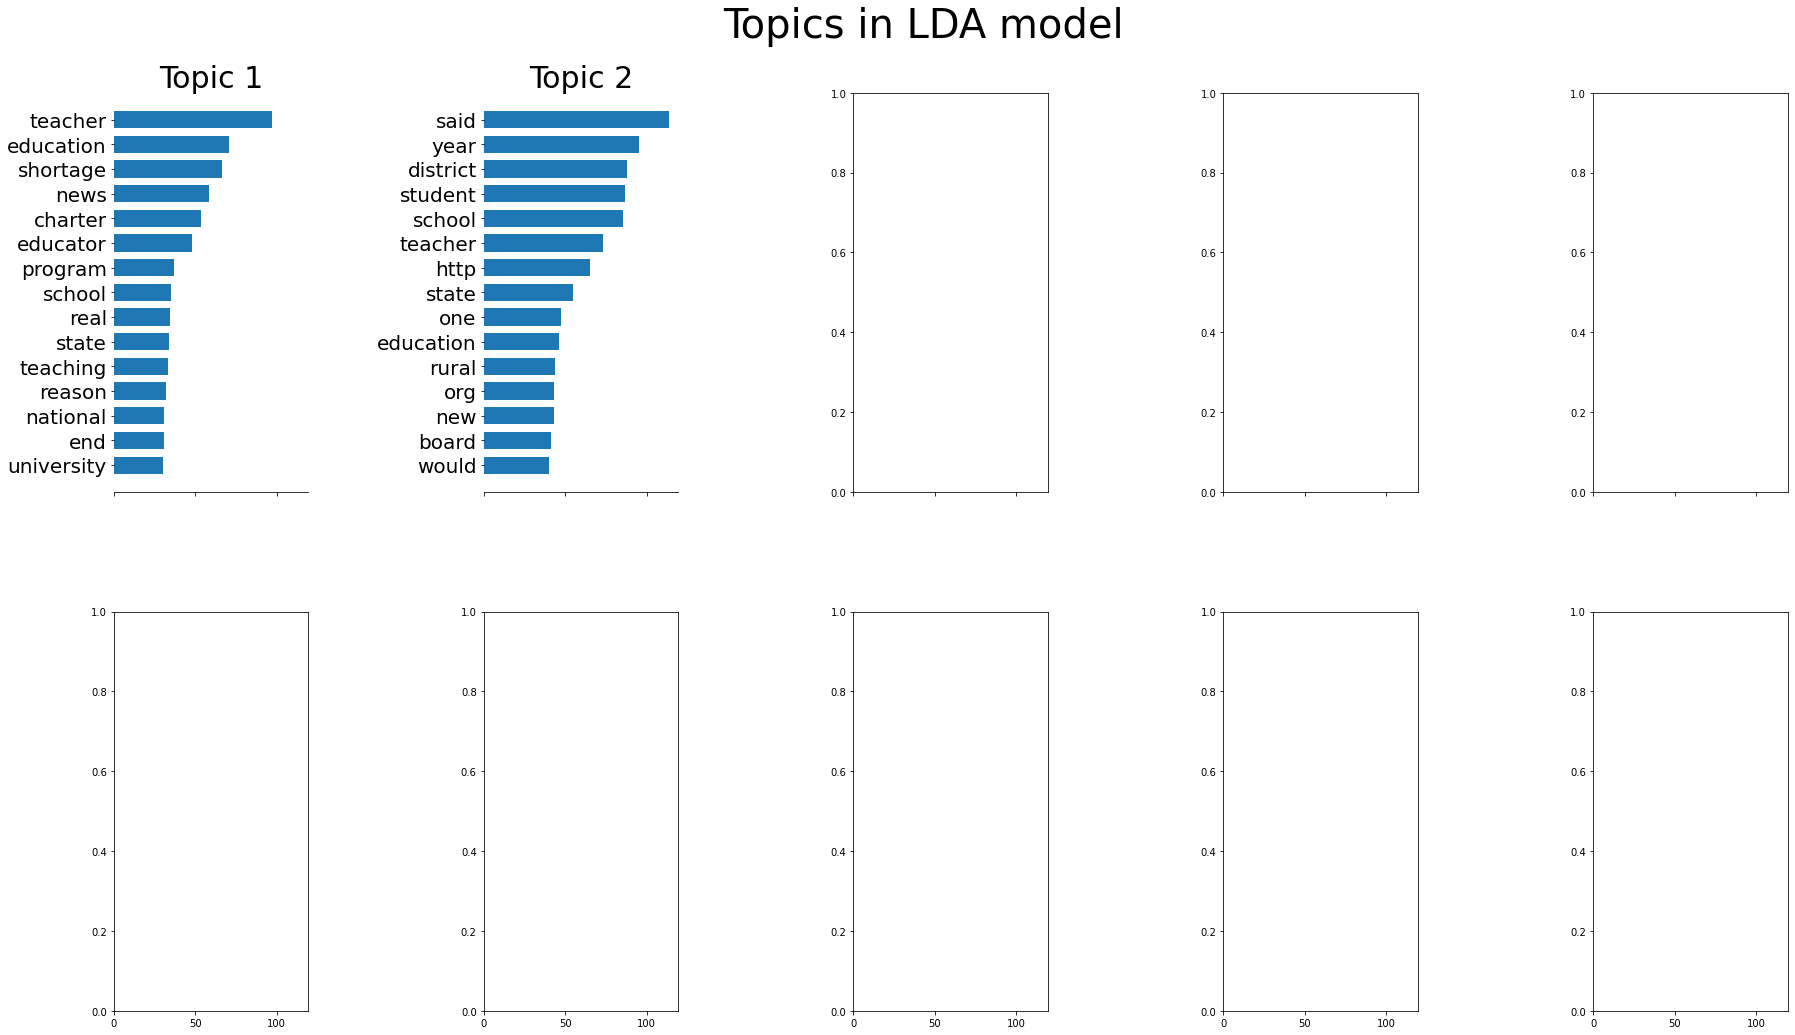

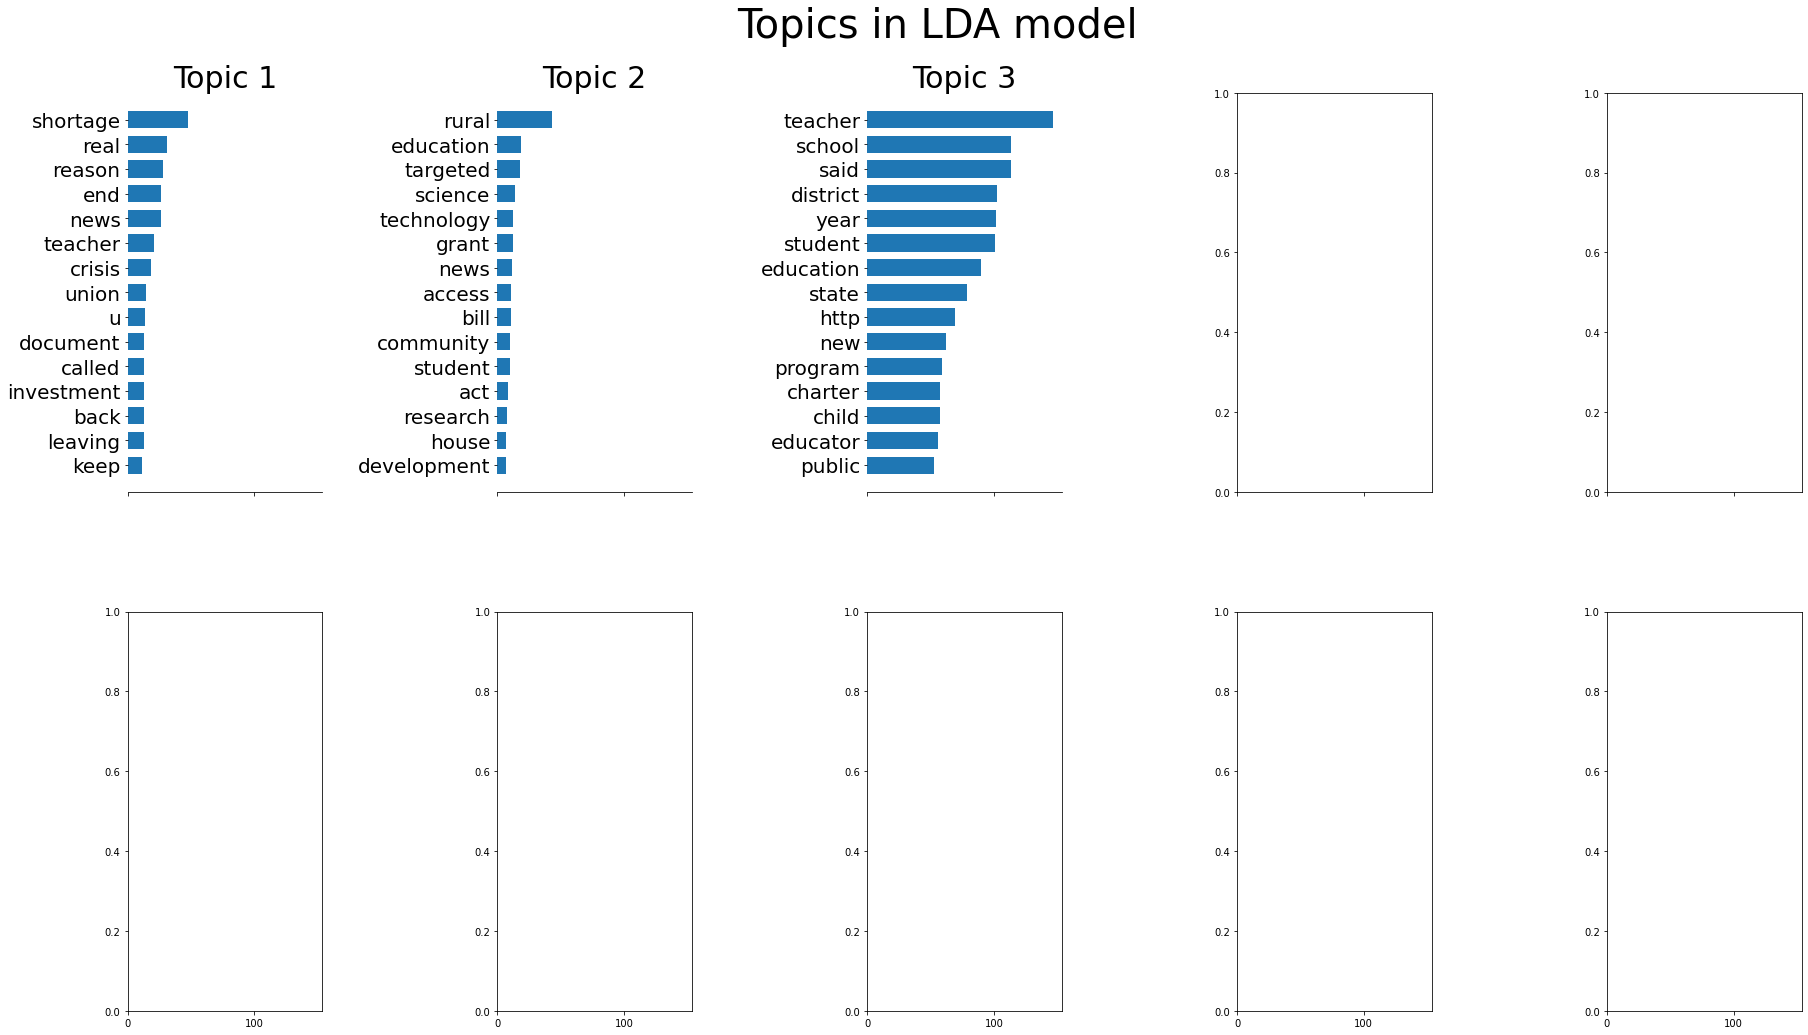

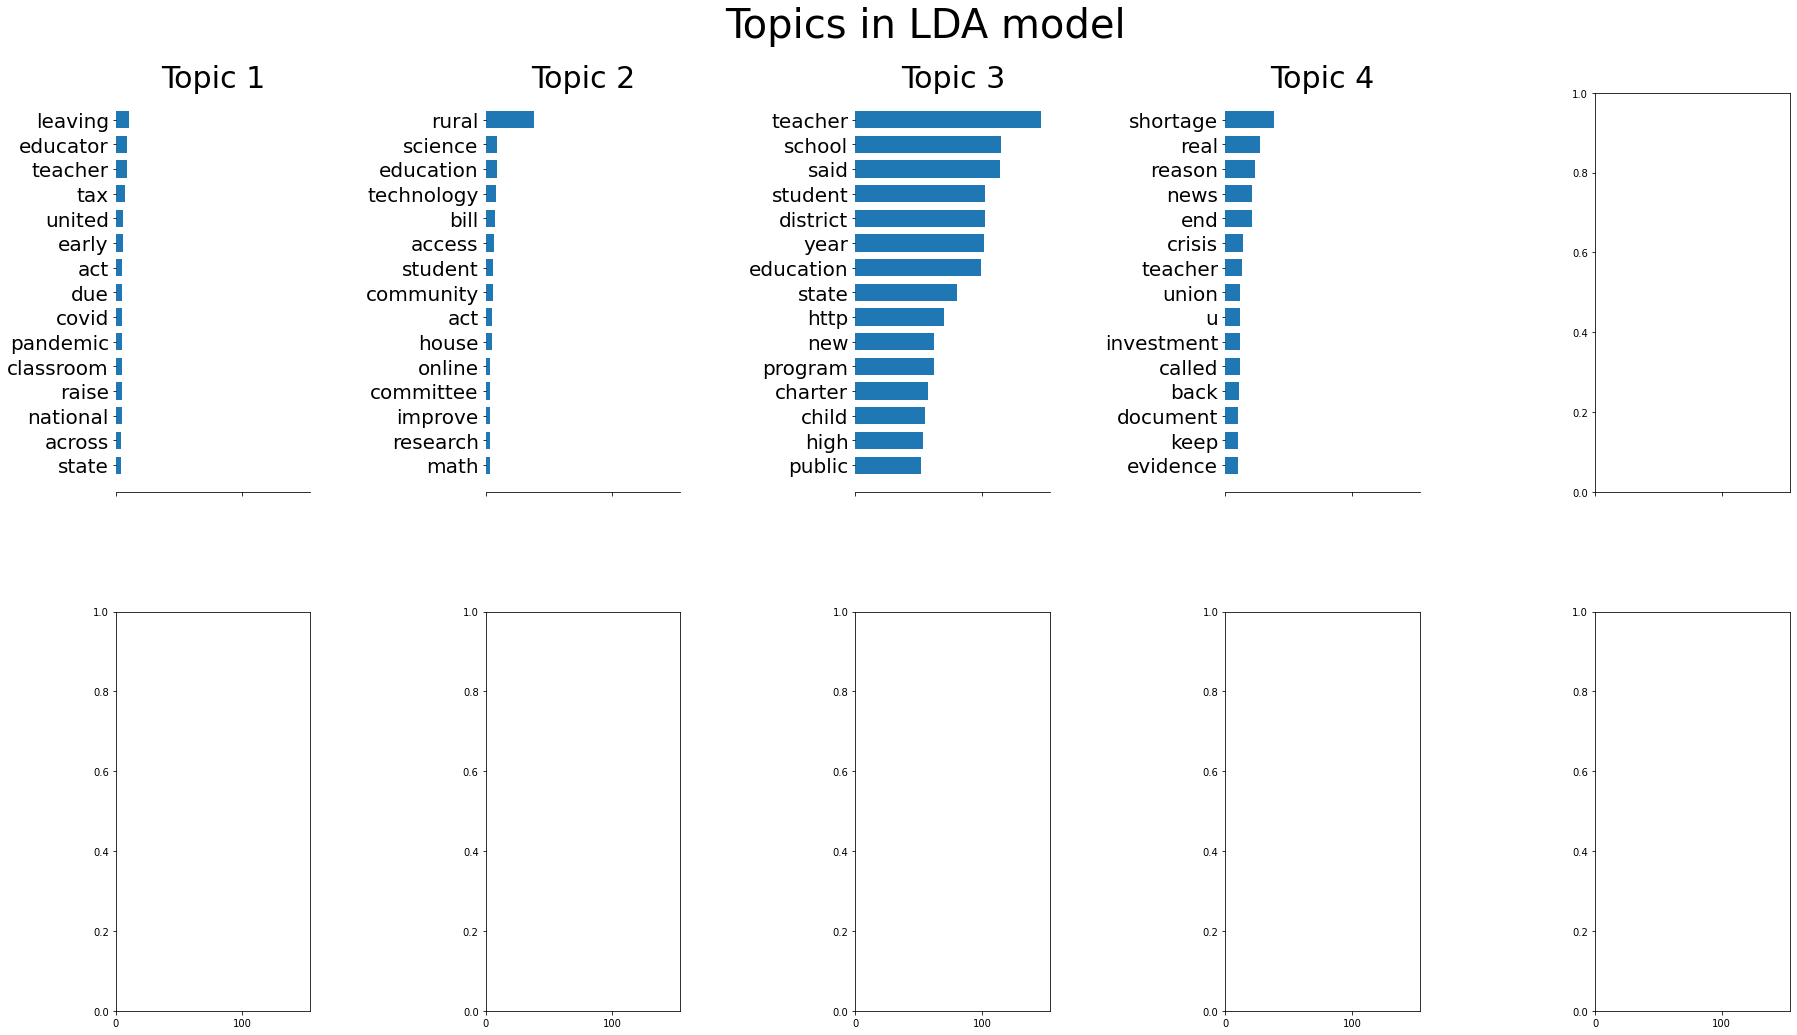

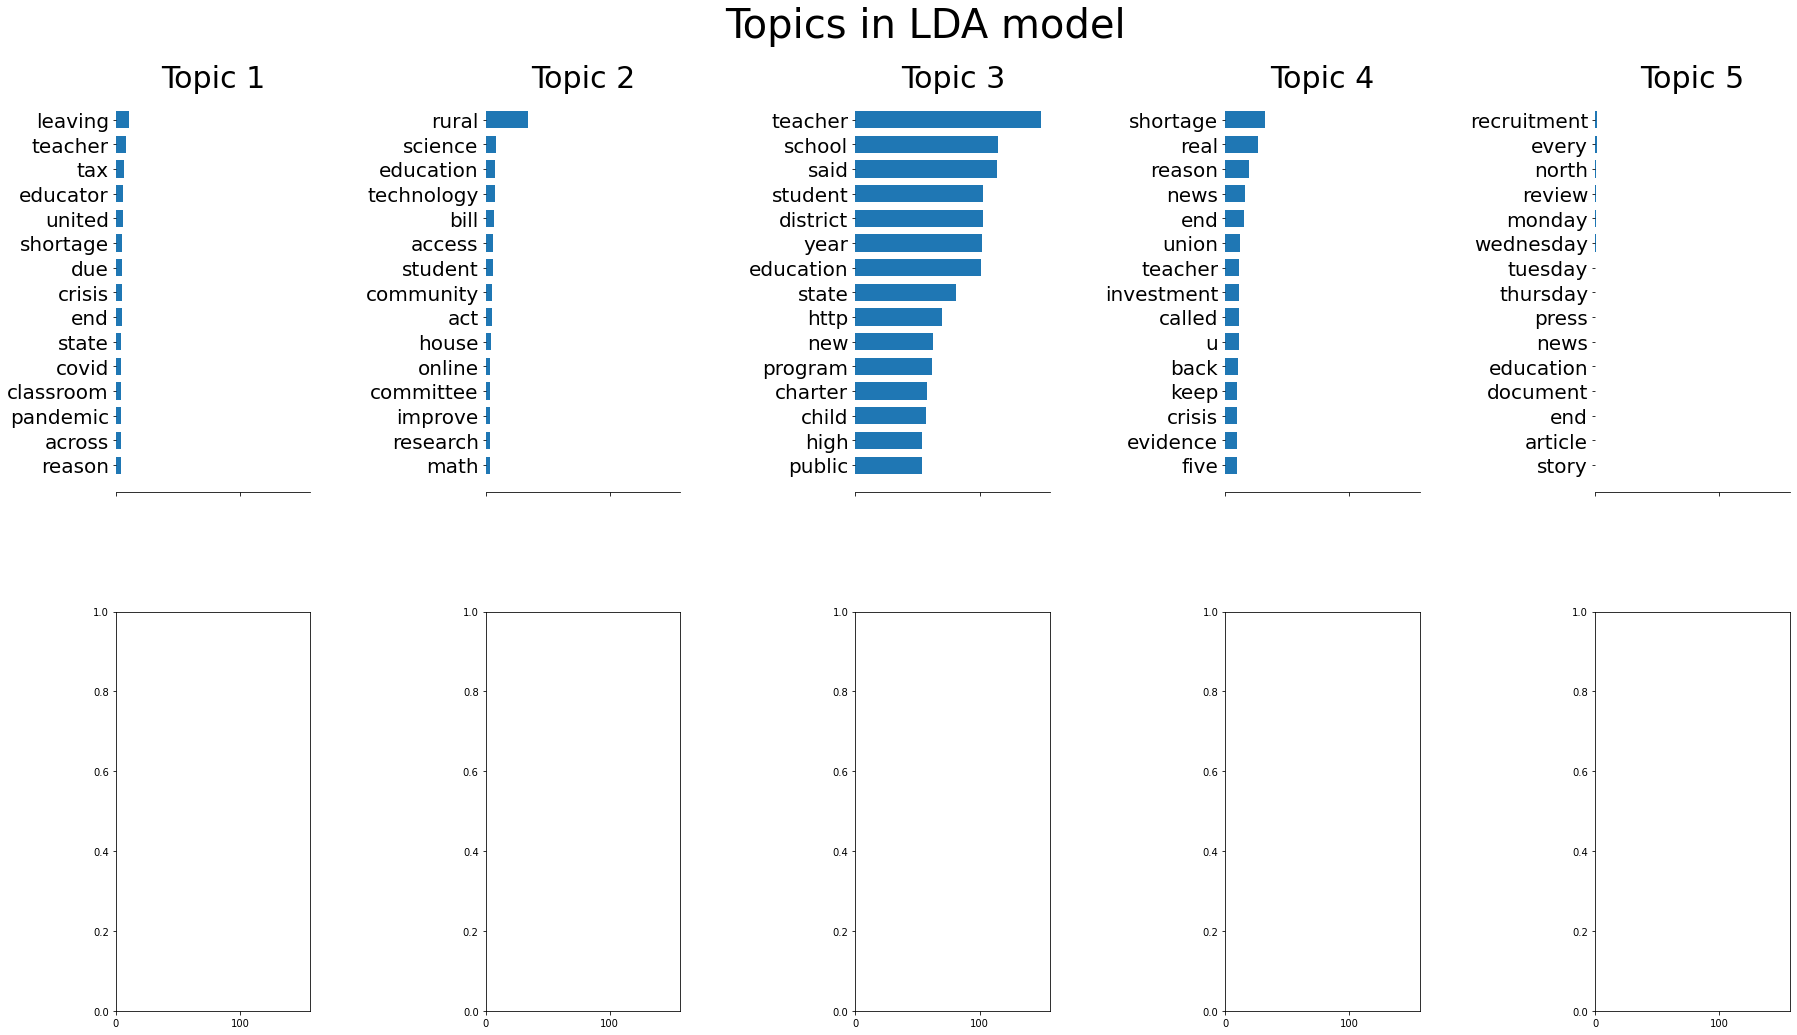

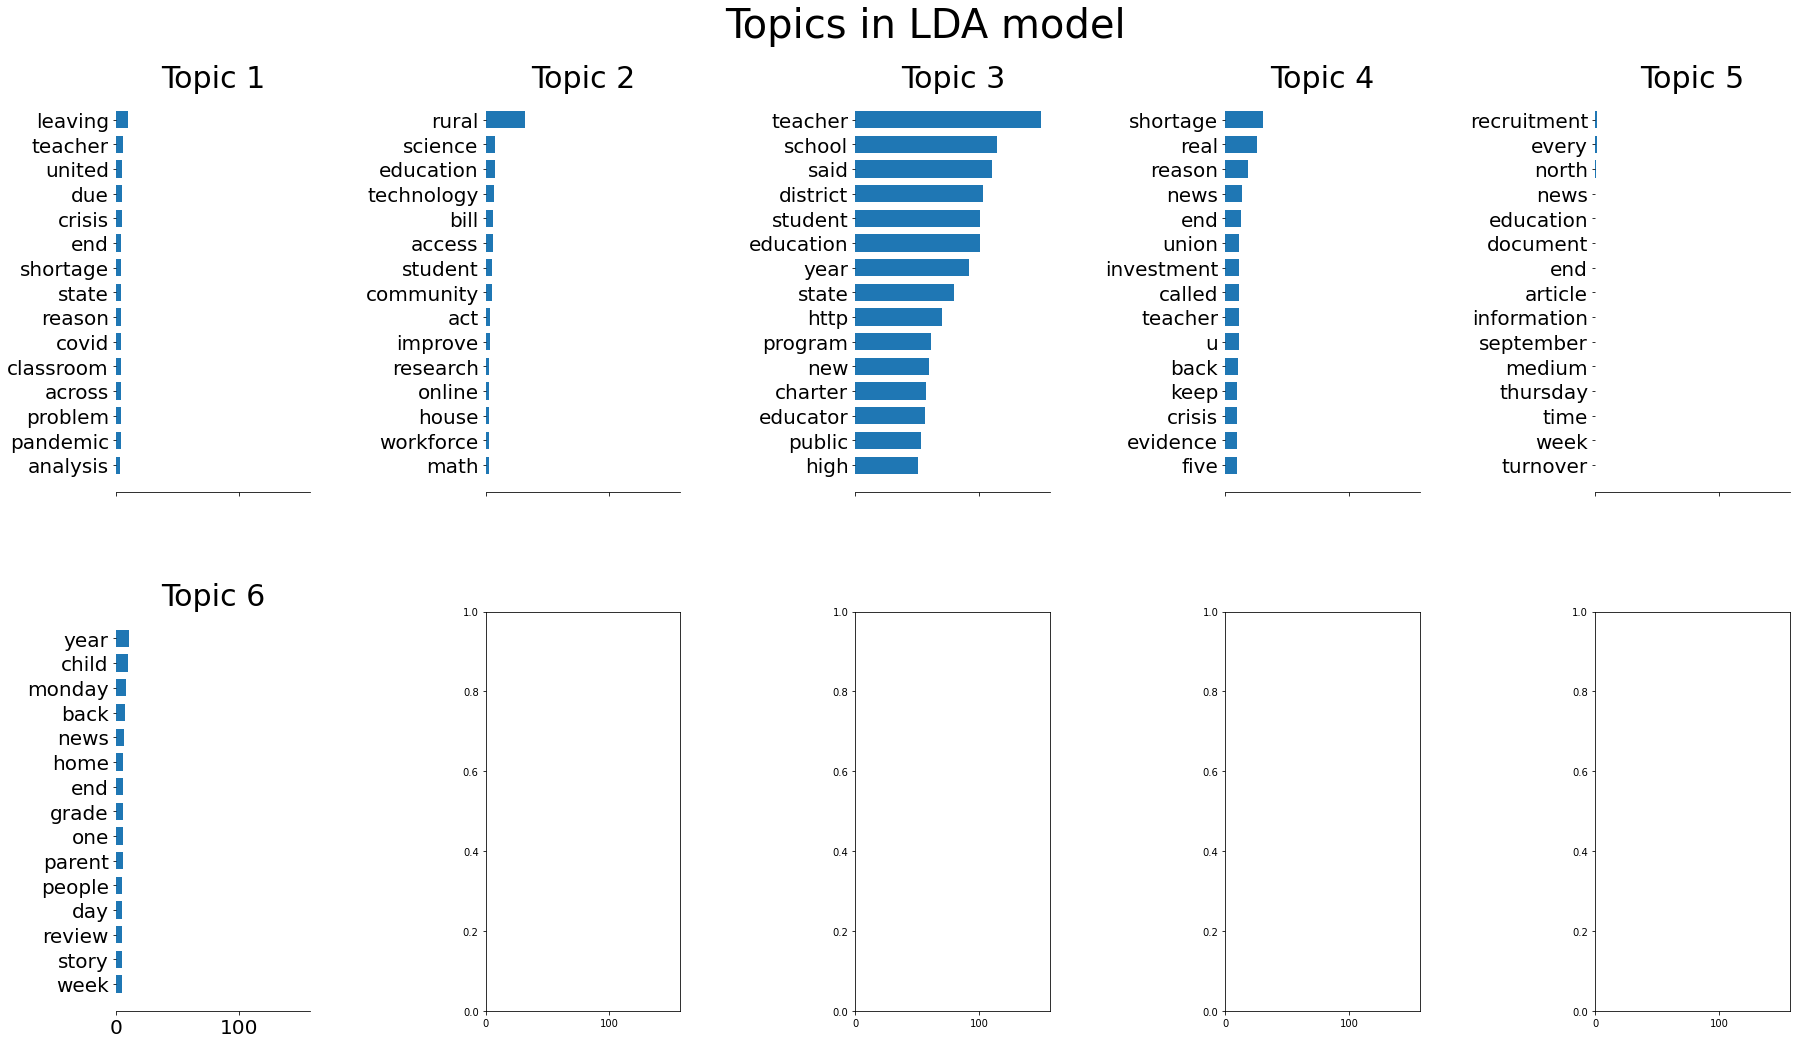

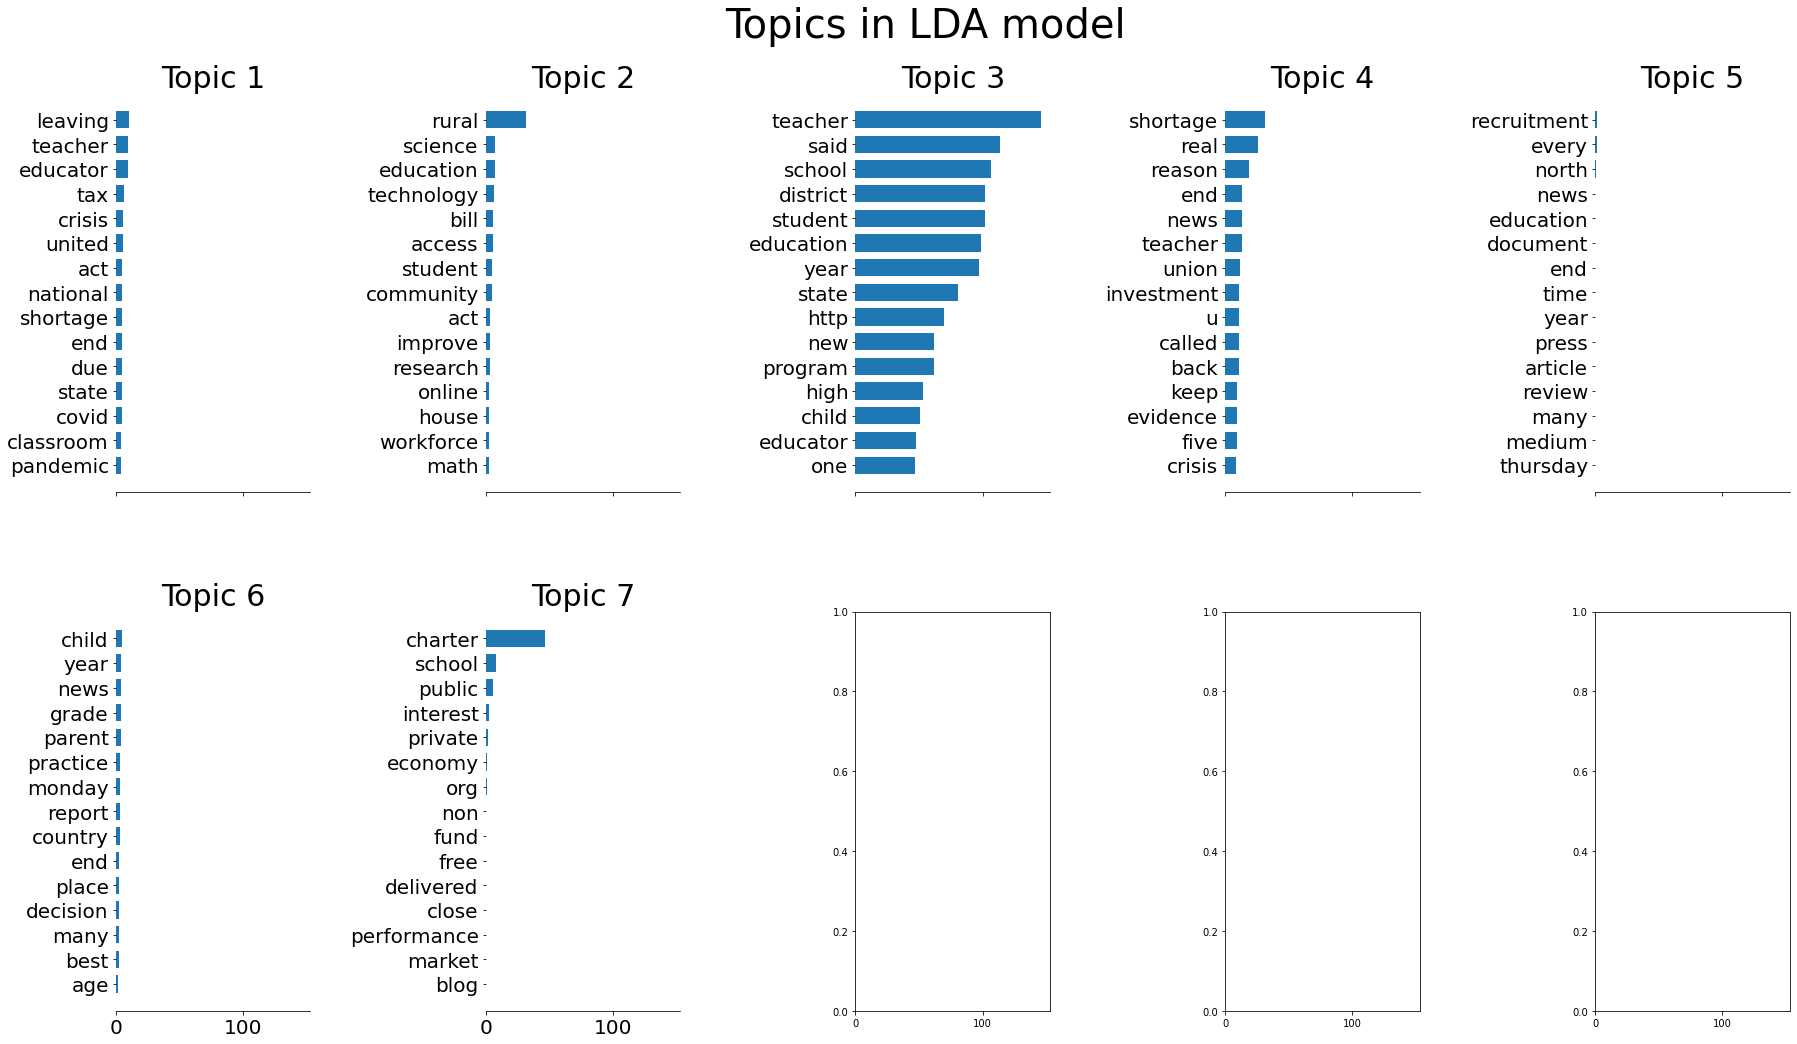

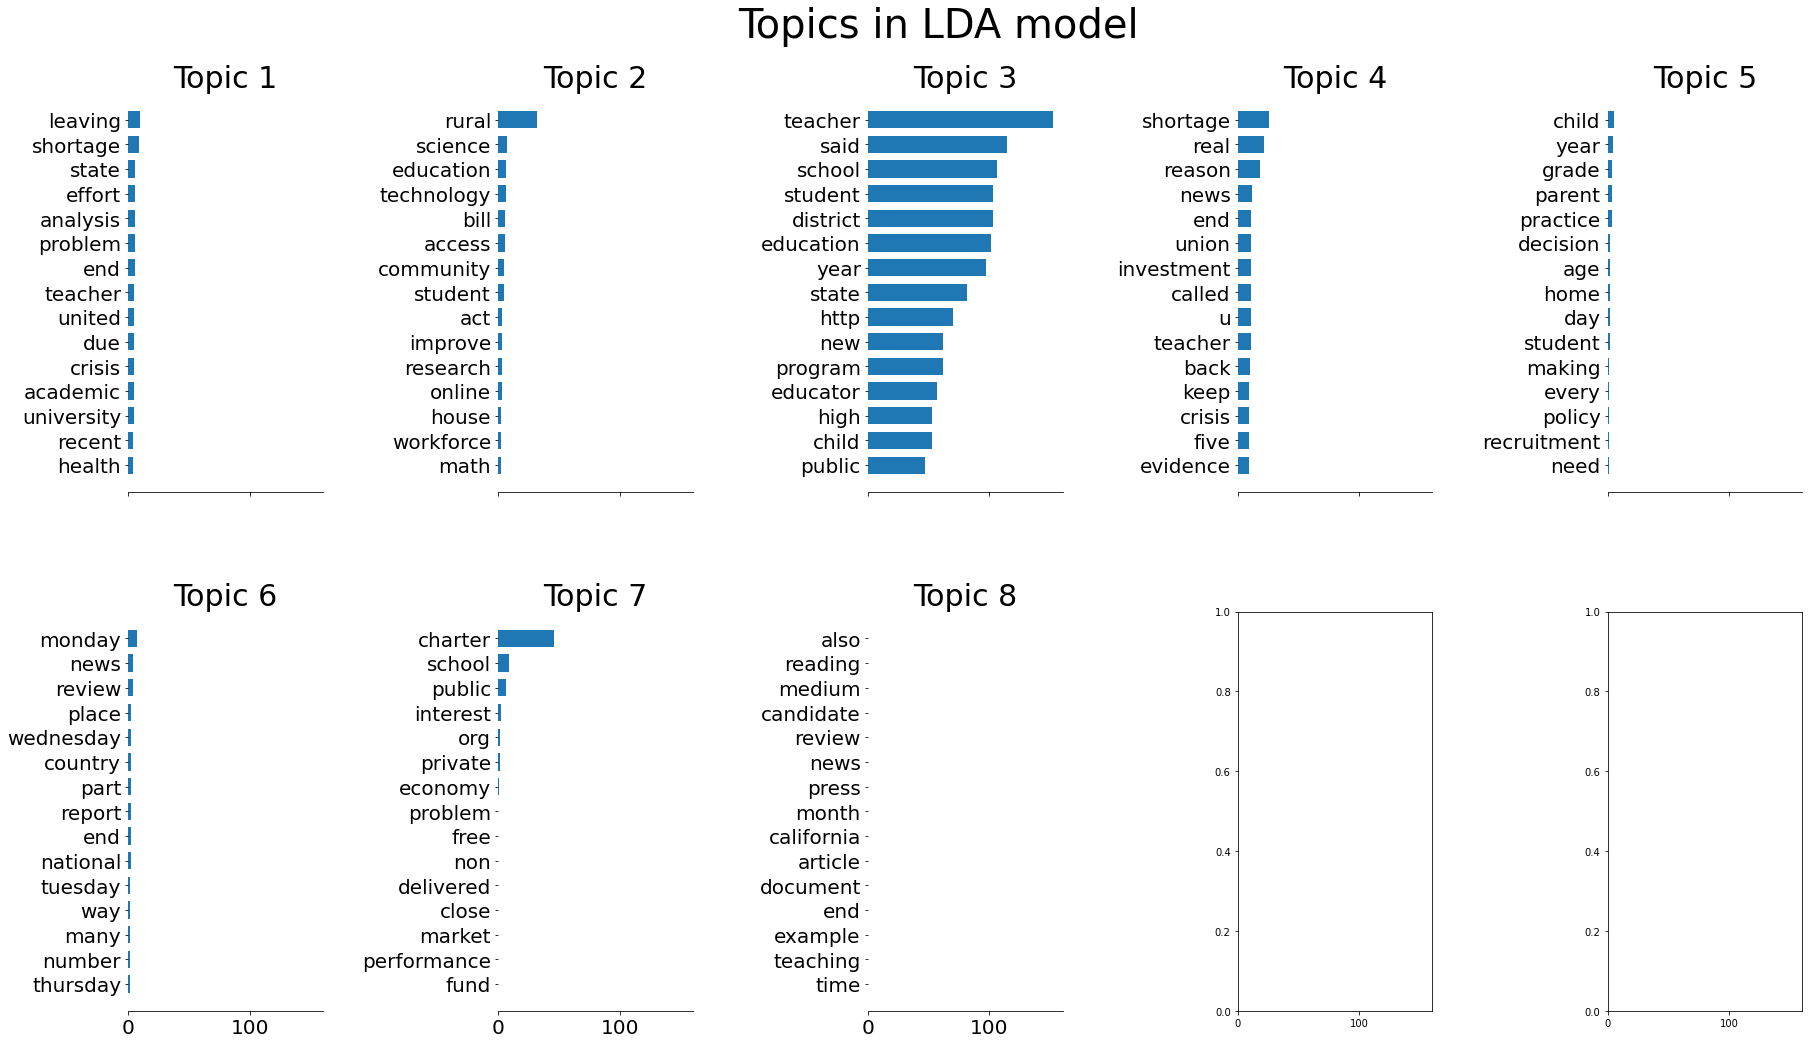

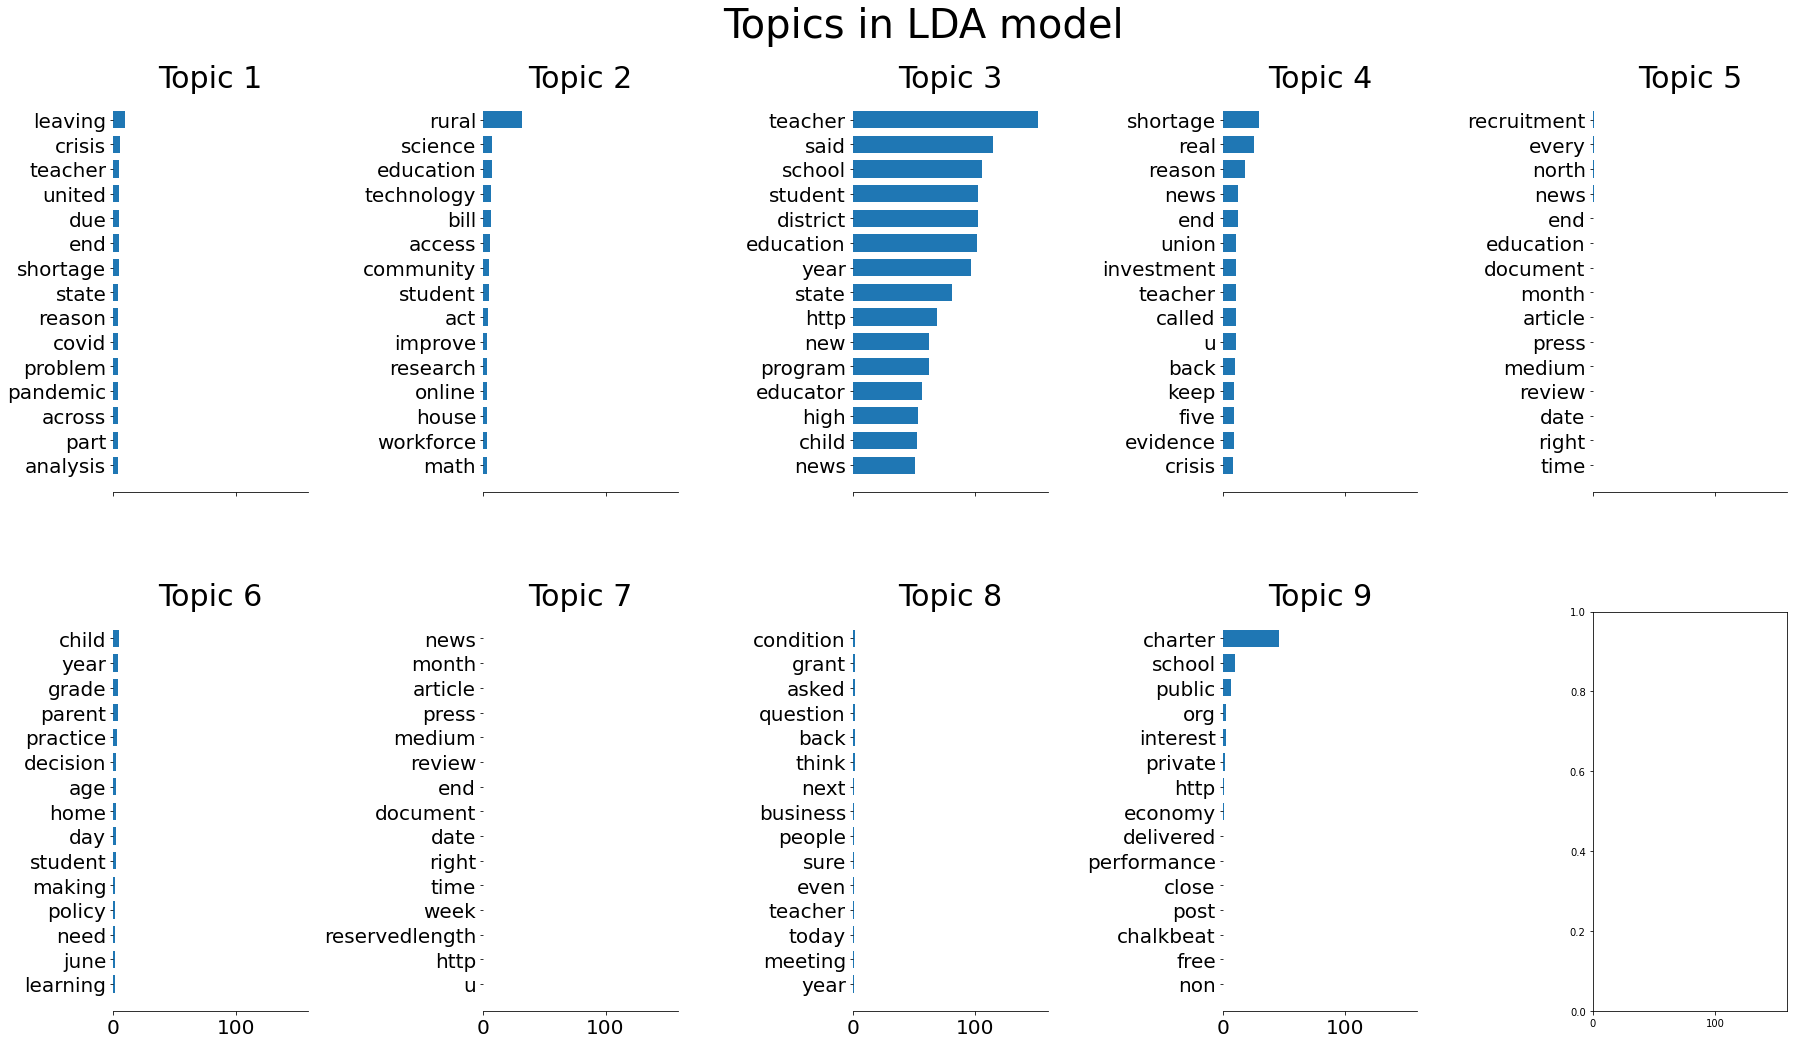

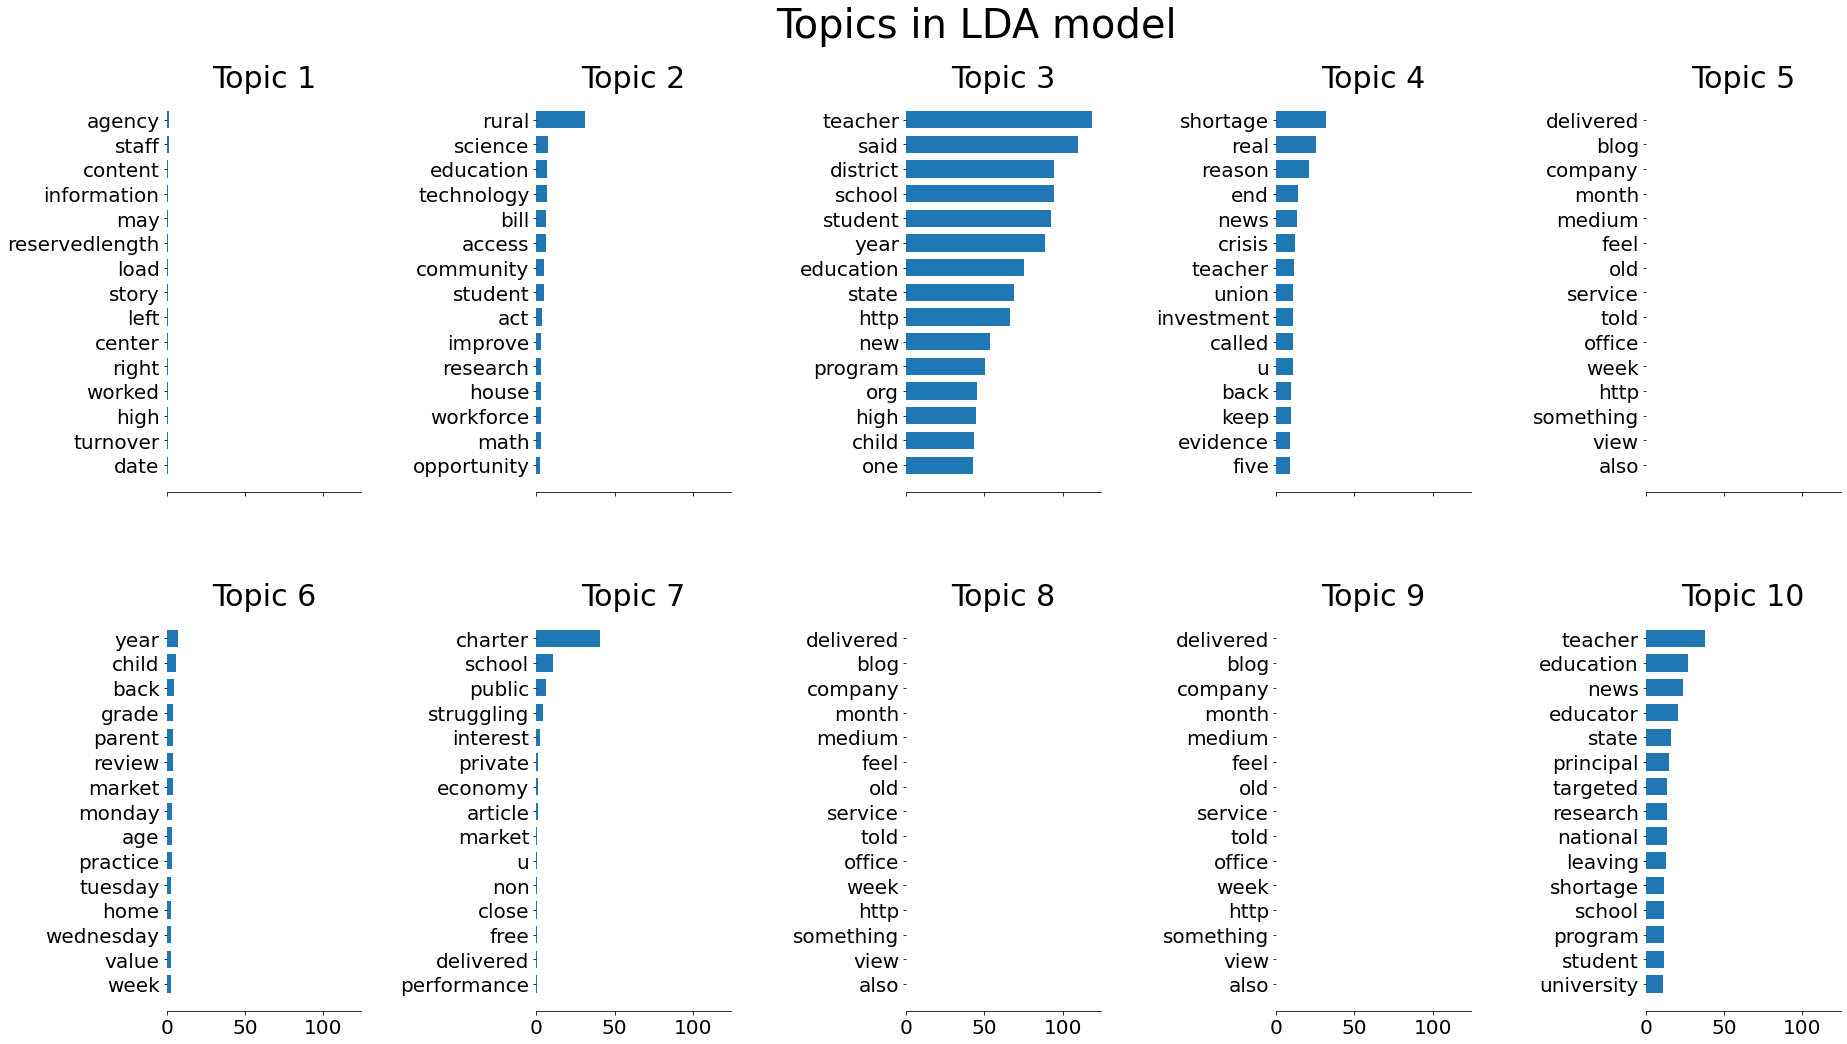

In [53]:
for i in range(10):
    LDA = LatentDirichletAllocation(n_components=i+1,random_state=0)
    theta = LDA.fit_transform(tfidf_trans_df)
    beta = LDA.components_
    #print_top_words(model=LDA, feature_names = features, n_top_words=20)
    plot_top_words(LDA, features, 15, "Topics in LDA model")

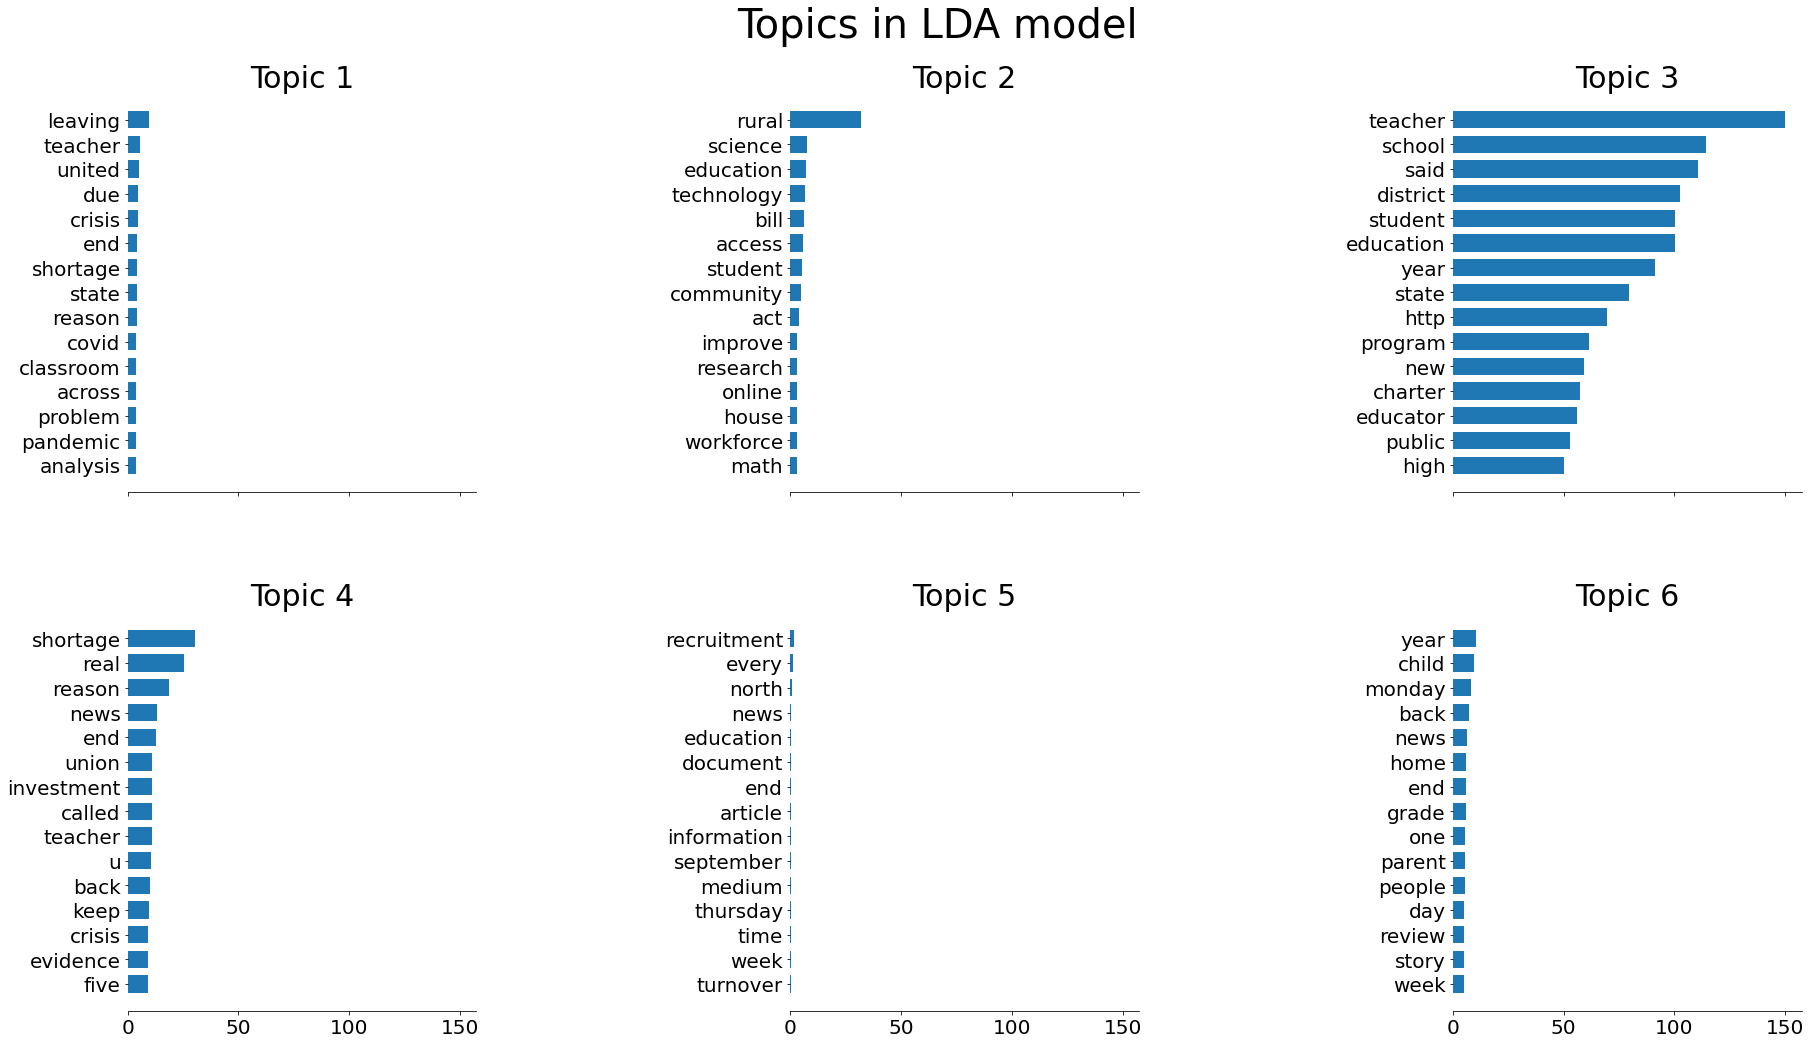

<Figure size 432x288 with 0 Axes>

In [120]:
LDA = LatentDirichletAllocation(n_components=6,random_state=0)
theta = LDA.fit_transform(tfidf_trans_df)
beta = LDA.components_
#print_top_words(model=LDA, feature_names = features, n_top_words=20)
plot_top_words(LDA, features, 15, "Topics in LDA model")
plt.savefig('plots/lda_topic_words.png')

In [121]:
topic_probabilities = pd.DataFrame.from_records(theta.round(2), 
                                                columns=["topic1","topic2","topic3","topic4","topic5","topic6"])

In [70]:
max(topic_probabilities.iloc[0])

0.9

In [122]:
most_likely_topic = []
for row in range(topic_probabilities.shape[0]):
    prob_values = topic_probabilities.iloc[row]
    for i in range(topic_probabilities.shape[1]):
        if prob_values[i] == max(prob_values):
            topic = f'topic{i+1}'
    most_likely_topic.append(topic)

In [127]:
most_likely_topic_series = pd.Series(most_likely_topic)
articles_without_outliers = pd.concat([articles_without_outliers,most_likely_topic_series],axis=1)

In [128]:
articles_without_outliers[["outlet","covid",0]]

,outlet,covid,0
0,Newstex Blogs,1.0,topic3
1,Fort McMurray Today,0.0,topic3
2,Newstex Blogs,1.0,topic3
3,The Philadelphia Inquirer,1.0,topic3
4,US Fed News,0.0,topic3
...,...,...,...
1314,NaN,NaN,topic3
1315,NaN,NaN,topic3
1316,NaN,NaN,topic3
1336,NaN,NaN,topic3


In [139]:
pd.crosstab(index=articles_without_outliers[0], columns=articles_without_outliers["covid"]).sum(axis=1)

0
topic1     22
topic2     27
topic3    906
topic4     49
topic5      2
topic6     44
dtype: int64

In [130]:
pd.crosstab(index=articles_without_outliers[0], columns=articles_without_outliers["covid"], normalize='index').round(3)

covid,0.0,1.0
0,,
topic1,0.591,0.409
topic2,0.519,0.481
topic3,0.343,0.657
topic4,0.163,0.837
topic5,0.000,1.000
topic6,0.341,0.659


In [131]:
pd.crosstab(index=articles_without_outliers[0], columns=articles_without_outliers["outlet"])

outlet,ABC News Transcript NIGHTLINE,Advance-Titan: University of Wisconsin - Oshkosh,Agriculture Monitor Worldwide,Alaska Dispatch News,Alaska Policy Forum,Albert Lea Tribune (Minnesota),All Things Considered All Things Considered,American School & University,"Appeal-Democrat, Marysville, Calif.",Arizona Capitol Times,...,Web newswire,WebNews - Academic,WebNews - English,White House Documents and Publications,"Wisconsin State Journal (Madison, Wisconsin)",Woodstock Sentinel-Review,bondbuyer.com,thestar.com,thesun.co.uk,thetimes.co.uk
0,,,,,,,,,,,,,,,,,,,,,
topic1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
topic2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,1,0
topic3,0,1,0,11,2,2,1,3,1,1,...,1,82,40,1,7,0,1,1,1,1
topic4,0,0,0,3,0,0,0,0,0,0,...,0,14,5,0,1,1,0,0,0,1
topic5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
topic6,1,0,1,0,0,0,0,0,0,0,...,0,4,2,0,0,0,0,0,0,0


In [132]:
afn = Afinn()
scores = [afn.score(doc) for doc in articles_without_outliers["text"].dropna()]
sentiment = ['positive' if score > 0
                          else 'negative' if score < 0
                              else 'neutral'
                                  for score in scores]

In [133]:
non_null_articles = articles_without_outliers[articles_without_outliers["text"].isna()==False]

In [134]:
non_null_articles['scores'] = scores
non_null_articles['sentiment'] = sentiment

C:\Users\abbyr\AppData\Local\Temp/ipykernel_9004/2806491026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_articles['scores'] = scores
C:\Users\abbyr\AppData\Local\Temp/ipykernel_9004/2806491026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_articles['sentiment'] = sentiment


In [135]:
non_null_articles[[0,"covid","scores","sentiment"]]

,0,covid,scores,sentiment
0,topic3,1.0,59.0,positive
1,topic3,0.0,15.0,positive
2,topic3,1.0,55.0,positive
3,topic3,1.0,25.0,positive
4,topic3,0.0,35.0,positive
...,...,...,...,...
1497,NaN,1.0,2.0,positive
1498,NaN,1.0,2.0,positive
1499,NaN,1.0,6.0,positive
1501,NaN,1.0,14.0,positive


In [136]:
non_null_articles["sentiment"].value_counts()

positive    920
negative    397
neutral      30
Name: sentiment, dtype: int64

In [137]:
pd.crosstab(index=non_null_articles[0], columns=non_null_articles["sentiment"], normalize='index').round(3)

sentiment,negative,neutral,positive
0,,,
topic1,0.261,0.000,0.739
topic2,0.172,0.034,0.793
topic3,0.306,0.025,0.669
topic4,0.426,0.000,0.574
topic5,0.000,0.000,1.000
topic6,0.180,0.020,0.800


In [140]:
non_null_articles[0].value_counts()

topic3    1029
topic4      68
topic6      50
topic2      29
topic1      23
topic5       2
Name: 0, dtype: int64

In [138]:
pd.crosstab(index=non_null_articles["covid"], columns=non_null_articles["sentiment"], normalize='index').round(3)

sentiment,negative,neutral,positive
covid,,,
0.0,0.221,0.005,0.774
1.0,0.238,0.019,0.743


In [141]:
non_null_articles["covid"].value_counts()

1.0    799
0.0    393
Name: covid, dtype: int64